# Recommendation Systems

In this notebook, we will apply many different recommendation techniques to the same problem: recommending someone his favorite glass of beer.

Recall we have the following methods at our disposal:

1. Content-based filtering (mapping items and users into a feature space)
  1. Computing distance between items and users using dot products
  1. Predicting ratings (or likes/dislikes) given the features
  
1. Collaborative filtering
  1. Item-based: compute similarity between items, recommend items most similar to user's items
  2. Model-based: use technqiues to find latent variables (i.e., deeper structure) in the ratings data, for example matrix decomposition techniques.  Ratings are constructed by taking dot products of user & item vectors in the latent feature space.
  

### Data Exploration

Please download the **[beer reviews](https://s3.amazonaws.com/demo-datasets/beer_reviews.tar.gz) dataset.** 

This dataset is also used by [another recommender example](http://nbviewer.ipython.org/gist/glamp/20a18d52c539b87de2af) in python.

#### Loading code and data 

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from patsy import dmatrix
import seaborn as sb
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
%%time
data = pd.read_csv("/Users/ruben/Downloads/beer_reviews/beer_reviews.csv")

CPU times: user 2.46 s, sys: 277 ms, total: 2.73 s
Wall time: 2.74 s


In [3]:
print "We have %d reviews for %d beers from %d breweries, by %d drinkers" % \
    (len(data), data.beer_beerid.nunique(), data.brewery_id.nunique(), data.review_profilename.nunique())

We have 1586614 reviews for 66055 beers from 5840 breweries, by 33387 drinkers


We could definitely truncate the data to speed up calculations. 

In [4]:
N = 150000
data = data.iloc[:N]
print "We have %d reviews for %d beers from %d breweries, by %d drinkers" % \
    (len(data), data.beer_beerid.nunique(), data.brewery_id.nunique(), data.review_profilename.nunique())

We have 150000 reviews for 6420 beers from 589 breweries, by 13964 drinkers


In [5]:
data.head(3)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215


#### Data exploration

Let's see per features how many categories we have.

In [6]:
for col in data:
    print "%-20s: %7d uniques" % (col, data[col].nunique())

brewery_id          :     589 uniques
brewery_name        :     589 uniques
review_time         :  149904 uniques
review_overall      :      10 uniques
review_aroma        :       9 uniques
review_appearance   :      10 uniques
review_profilename  :   13964 uniques
beer_style          :     102 uniques
review_palate       :       9 uniques
review_taste        :       9 uniques
beer_name           :    6101 uniques
beer_abv            :     177 uniques
beer_beerid         :    6420 uniques


Note that
- our items are in `beer_beerid` (note that the names in `beer_name` are not unique),
- our users are `review_profilename`,
- we will use `review_overall` as rating, although we have many more (`aroma`, `appearance`, `profilename`, `palate`, and `taste`)
- we have only a few features: `brewery_id` (or `brewery_name`), `beer_abv` (% alcohol), and `beer_style`. We'll ignore `review_time`, although you might be able to spot differences in popularity over time.

Since the beer names are not unique, we will use the beer IDs. Let's make a lookup table from `id` to name, so we can easily tract the beer's name as well.

In [7]:
beer_names = data.groupby('beer_beerid').beer_name.first()  # only one name per ID

Let's make sure we know the distribution of what we'd like to predict.

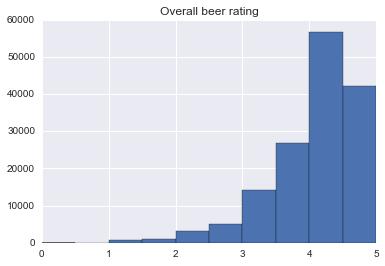

In [8]:
f = data.review_overall.hist(bins=10)
f = plt.title("Overall beer rating")

Also note that the beer-drinker reviews are not unique, as some people have filed multiple reviews per beer.  We generally take the average rating in such case.

In [9]:
n_reviews = data.groupby(['beer_beerid', 'review_profilename']).review_overall.nunique()
n_reviews.value_counts()

1    147421
2       930
3        13
dtype: int64

<hr>
## Content-based filtering

Content-based filtering maps the data into a feature space, in which we can compare beers and drinkers.  Each beer will get a representation in this space (a high alcohol, IPA-like beer from Founders brewery).  Each drinker gets a taste profile (likes high alcohol beers, likes IPAs but dislikes anything from Founders).

Unfortuantely we don't have many features: just three, really: brewery, style and alcohol percentage (ABV).  We can definitely create additional features by using each word from the beer style (e.g., "IPA" from "Imperial IPA") or its name even (e.g., "Ginger" from "Caldera Ginger Beer").  We will leave this as an exercise.

We use the brewery as a feature, but it is not sure this is a useful feature, and it might cause overfitting.

#### Creating feature matrix

We will categorize the ABV feature into bins.

In [10]:
min_bin, max_bin = 4, 10
abv = data.beer_abv.round()
abv[abv <= min_bin] = min_bin  # low-alcohol beers in one bin
abv[abv >= max_bin] = max_bin  # high-alcohol beers in one bin

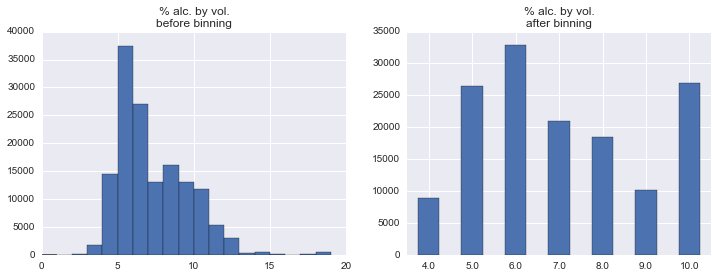

In [11]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
f = data.beer_abv.hist(bins=range(0, 20), ax=axes[0])
axes[0].set_title("% alc. by vol.\nbefore binning")
f = abv.value_counts().sort_index().plot(
    kind='bar', rot=0, ax=axes[1], title="% alc. by vol.\nafter binning")

We convert numerical values to strings, so patsy will treat them as categorical features

In [12]:
data['beer_abv_cat'] = abv.dropna().astype(int).astype(str)
data['brewery_id_str'] = data.brewery_id.astype(str)
X_abv_brew = dmatrix('beer_abv_cat + brewery_id_str', data=data.fillna(0), return_type='dataframe')
X_abv_brew.shape

(150000, 596)

Let's use each word in the beer style as a feature as well (e.g., "IPA")

In [13]:
%%time
max_features = 5000
cv = CountVectorizer(max_features=max_features)
X_style = cv.fit_transform(data.beer_style)

CPU times: user 773 ms, sys: 20.2 ms, total: 793 ms
Wall time: 784 ms


In [14]:
X = np.hstack([X_abv_brew, X_style.toarray()])
y = data.review_overall
n_samples, n_features = X.shape

Done! Now we have a feature matrix $X$ with ratings in $y$, containing both beers and drinkers.

#### Dot-product method

Since the features only describe beer characteristics, each beer entry in $X$ has the same values for the same beer. So we can just take a beer's first occurance for its representation.

In [16]:
uniques, idx = np.unique(data.beer_beerid, return_index=True)
beer_features = pd.DataFrame(X[idx, :], index=data.beer_beerid[idx])
print beer_features.shape
beer_features.head(2)

(6420, 716)


,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
beer_beerid,,,,,,,,,,,,,,,,,,,,,
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


A drinker, however, has different ratings for each beer. Per entry, we will broadcast his or her ratings over the features.

For example,

            low-abv  high-abv  IPA  Stout  Pilsner rating
    beer 1     1        0       0     0       1     2.0
    beer 2     0        1       1     0       0     4.5
    
...will become...

            low-abv  high-abv  IPA  Stout  Pilsner
    beer 1    2.0       0       0     0      2.0
    beer 2     0       4.5     4.5    0       0 
    
... and then we average all ratings per user to get a user profile. We also subtract 3 from each rating, so bad ratings are negative and good ratings positives. This is to compensate for all missing entries, which automoatically get a zero-rating (and are now rated as average, instead of terribly bad).

In [17]:
%%time
reviewer_features = pd.DataFrame(X * (data.review_overall.values - 3).reshape(n_samples, 1))
reviewer_features['review_profilename'] = data.review_profilename
reviewer_features = reviewer_features.groupby('review_profilename')[range(n_features)].mean()
reviewer_features = reviewer_features.divide(reviewer_features.sum(axis=1), axis=0)

CPU times: user 1.07 s, sys: 624 ms, total: 1.69 s
Wall time: 1.63 s


In [18]:
reviewer_features.head(2)

,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.168582,0.08046,0,0,0.038314,0.022989,0.030651,-0.003831,0,0,...,0,0,0,0,0,0.000000,0.011494,0,0.003831,0
05Harley,0.173554,0.07438,0,0,0.024793,0.041322,0.016529,0.016529,0,0,...,0,0,0,0,0,-0.008264,0.000000,0,0.000000,0


We now simply take the dot product of the beer vector and the drinker vector.  This means that we will add a user's ratings for each of the beer's features.  

Let's pick an arbitrary user.

In [19]:
user = 'WesWes'

Compute user's vector and all beer vectors, and take dot product.

In [20]:
v = reviewer_features.loc[user].values
M = beer_features.values
pred = M.dot(v)

# Now index this vector with the actual beers, so we can understand the values
pred = pd.Series(pred, index=beer_features.index, name="predictions") \
    .sort(ascending=False, inplace=False)
pred_name = pd.Series(pred.values, beer_names[pred.index], name=pred.name)

print "Top recommendations for %s" % user
print pred_name.head()

print "\nBottom  recommendations (don't drink these, %s!)" % user
print pred_name.tail()

Top recommendations for WesWes
beer_name
Sierra Nevada Pale Ale                  0.409924
Extra Special Pale Ale (ESP)            0.409924
Founders Brassworks Ale                 0.404890
Allocation Ale - Beer Camp #52          0.401654
Sierra Nevada Draught Style Pale Ale    0.401654
Name: predictions, dtype: float64

Bottom  recommendations (don't drink these, WesWes!)
beer_name
Europa Schwartz Pils         0.174038
Bald Eagle Kristallweizen    0.174038
Roggenbier                   0.174038
Zwickelbier                  0.174038
Replic Ale (2010)            0.174038
Name: predictions, dtype: float64


How do they compare with his actual reviews?  (Note that we take the mean since multiple reviews per drinker-beer pair occur.)

In [21]:
my_reviews = data[data.review_profilename == user].groupby('beer_beerid').review_overall.mean()\
    .sort(ascending=False, inplace=False)
my_reviews_name = pd.Series(my_reviews.values, index=beer_names[my_reviews.index])
print "Top reviewed by %s" % user
print my_reviews_name.head()
print "\nBottom reviewed by %s" % user
print my_reviews_name.tail()

Top reviewed by WesWes
beer_name
Black Tuesday                              5
Founders KBS (Kentucky Breakfast Stout)    5
Northern Hemisphere Harvest Wet Hop Ale    5
Stoudt's Double IPA (India Pale Ale)       5
Founders CBS Imperial Stout                5
dtype: float64

Bottom reviewed by WesWes
beer_name
Weizen Berry                               3
Heineken Premium Light Lager               3
Pikop Andropov's Rushin' Imperial Stout    3
ESB Amber Ale                              3
Organic Münster Alt                        3
dtype: float64


Let's compare them all.

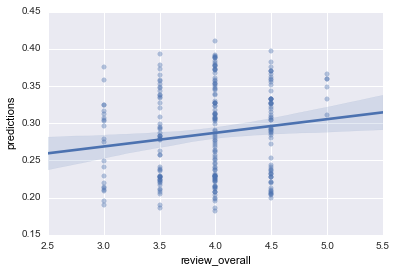

In [22]:
f = sb.regplot(my_reviews, pred[list(my_reviews.index)], scatter_kws=dict(alpha=.4))

Not bad. Note that we completely ignored overfitting and cross validation for readability's sake.

#### Linear Regression

Given this feature matrix and user reviews, we could also use a simple linear regression to predict a review for a user.  We will limit our dataset to the reviews of one user only, and then feed those into the model.

In [23]:
print "Filtering reviews by %s." % user
idx = (data.review_profilename == user).values  # filter reviews of user
X_user, y_user = X[idx, :], y[idx]
print X_user.shape, y_user.shape

Filtering reviews by WesWes.
(253, 716) (253,)


In [24]:
model = Ridge()
model.fit(X_user, y_user)
print cross_val_score(model, X_user, y_user, scoring='mean_absolute_error')
print cross_val_score(model, X_user, y_user, scoring='r2')

[-0.42260271 -0.39218923 -0.38307428]
[-0.22913789 -0.14327301  0.04404437]


Pretty bad cross-validation scores, but mind you we have only a handful reviews.

In [25]:
uniques, idx = np.unique(data.beer_beerid, return_index=True)  # find beer labels
pred = pd.Series(model.predict(X[idx, :]), index=data.beer_beerid[idx], name="predictions") \
    .sort(ascending=False, inplace=False)
pred_name = pd.Series(pred.values, beer_names[pred.index], name="predictions")
print "Top recommendations for %s." % user
print pred_name[:5]

Top recommendations for WesWes.
beer_name
Sierra Nevada Imperial Stout                               4.796611
Able I.P.A.                                                4.790692
The Colonel's Porter                                       4.780963
The Colonel's Porter (Cask Primed With English Treacle)    4.780963
Samson                                                     4.752497
Name: predictions, dtype: float64


Let's see how those relate to his actual reviews.

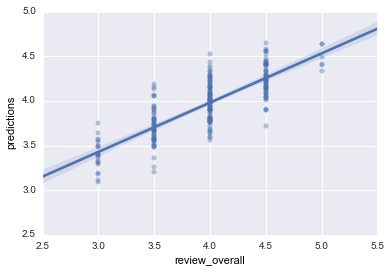

In [26]:
f = sb.regplot(my_reviews, pred[list(my_reviews.index)], scatter_kws=dict(alpha=.4))

Pretty spectacular. 

Just for the fun of it, how will this user rate a random beer?

In [27]:
beer = np.random.choice(beer_names.index)
beer_idx = (data.beer_beerid == beer).values
X_beer = X[beer_idx, :][0]  # just take the first entry
print "%s will give beer %s a rating of %.1f" % (user, beer_names[beer], model.predict(X_beer)[0])

WesWes will give beer Mike Duggan #17 Czech Pilsener a rating of 3.4


<hr>

## Collaborative filtering

With content-based filtering, we mapped our items and users into some feature space, in which we did our calculations. With _collaborative filtering_, however, we will not use any external features, but compare items with users directly.  This has as a great advantage we can give recommendations based on seemingly unrelated topics.  For example, we can keep track of someone's beer and movie ratings, and predict beer tastes based on someone's movie preferences (assuming there's a correlation between the two).

We have two kinds of collaborative filtering, _item-based_ and _model-based_.

### Item-based collaborative filtering

For _item-based collaborative filtering_, recommendations for are user are based on similar items that the user has already rated highly. It's the approach known as "because you liked this, we think you'd also like this..".  This method is also called _memory-based collaborative filtering_.  These neighborhood methods are popular and easy to understand, but they don’t scale well. 

In [28]:
# Create beer x drinker preference matrix
M = data.groupby(['beer_beerid', 'review_profilename']).review_overall.mean().unstack()
M = np.maximum(-1, (M - 3).fillna(0) / 2.)  # scale to -1..+1  (treat "0" scores as "1" scores)
M.head(2)

review_profilename,0110x011,05Harley,0tt0,100floods,100proof,1099.0,110toyourleft,1121987.0,11osixBrew,11thFloorBrewing,...,ztruempy,zuccard,zuffenhausen,zuggy9,zuker,zumicroom,zwoehr,zymurgy4all,zymurgywhiz,zythus
beer_beerid,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
%%time
n_ratings = data.groupby(['beer_beerid', 'review_profilename']).size()
n_ratings[n_ratings  > 1] = 1  # just keep 1 or 0 for user-beer rating
n_ratings = n_ratings.unstack().fillna(0)  # create matrix, fill empty cells with 0
n_ratings = n_ratings.dot(n_ratings.T)  # how many ratings do two beers have in common?

CPU times: user 35.7 s, sys: 730 ms, total: 36.4 s
Wall time: 9.04 s


In [30]:
%%time
# if we have `ignore_up_to_n` or less common ratings between two beers, just ignore it
ignore_up_to_n = 3
n_ratings = np.maximum(ignore_up_to_n, n_ratings).replace(ignore_up_to_n, np.nan)

CPU times: user 1.36 s, sys: 409 ms, total: 1.77 s
Wall time: 1.78 s


In [31]:
%%time
sim = M.dot(M.T)  # total score in common between two beers
sim = sim / n_ratings  # scale so we get an average score (not a sum)
# note that if we have no common ratings, we get a NaN now

CPU times: user 34.1 s, sys: 519 ms, total: 34.6 s
Wall time: 5.52 s


In [32]:
n_ratings = data.groupby(['beer_beerid']).size()
beers = n_ratings[n_ratings > 10].index

In [33]:
n_beers = 5
top = 5
print 
for beer in np.random.choice(beers, n_beers):
    print "--", beer_names[beer], "--"
    sim_beers = sim[beer].sort(ascending=False, inplace=False).dropna()
    if len(sim_beers) == 0:
        print "Not enough comparisons"
    else:
        print "MOST  similar:", ", ".join(beer_names[list(sim_beers.head(top).index)])
        print "LEAST similar:", ", ".join(beer_names[list(sim_beers.tail(top).index)])
    print


-- Pilsner --
MOST  similar: Pilsner, Stoudts Pils, Saison Rue, Sierra Nevada Porter, Founders Breakfast Stout
LEAST similar: 30th Anniversary - Jack & Ken's Ale, Weiss Beer, Sierra Nevada Bigfoot Barleywine Style Ale, Sierra Nevada Southern Hemisphere Harvest Fresh Hop Ale, 30th Anniversary- Charlie, Fred And Ken's Bock

-- The Legendary Duff Beer --
MOST  similar: The Legendary Duff Beer, Life & Limb, Founders Breakfast Stout, Hottenroth Berliner Weisse, Sierra Nevada Kellerweis Hefeweizen
LEAST similar: Sierra Nevada Bigfoot Barleywine Style Ale, 2XIPA, Coopers Best Extra Stout, Old Viscosity, Ichtegem's Grand Cru

-- Saint Landelin La Divine --
MOST  similar: Vuja De, Tocobaga Red Ale, Naughty Nellie's Ale, Hunahpu's Imperial Stout - Laird's Apple Brandy Barrel, Harvest Ale
LEAST similar: Cherry Chocolate Beer, Werewolf, Werewolf (Green Label), Bière Du Démon, St. Ides High Gravity Malt Liquor

-- Flemish Red Ale Grand Cru --
MOST  similar: Verhaeghe Echte Kriek / Echte Kriekenbie

Hmm, not super convincing yet.

#### Recommendations for a user

Let's look at our old friend again.

In [34]:
print "Top reviews by %s." % user
print my_reviews_name.head()

Top reviews by WesWes.
beer_name
Black Tuesday                              5
Founders KBS (Kentucky Breakfast Stout)    5
Northern Hemisphere Harvest Wet Hop Ale    5
Stoudt's Double IPA (India Pale Ale)       5
Founders CBS Imperial Stout                5
dtype: float64


In [35]:
top = 5
favorite_beers = list(my_reviews[my_reviews > 4].index)
pred = sim[favorite_beers].mean(axis=1).dropna().sort(ascending=False, inplace=False)
pred_name = pd.Series(pred.values, beer_names[pred.index], name=pred.name)
print "Top recommendations for %s" % user
print pred_name.head()
print "\nBottom  recommendations (don't drink these, %s!)" % user
print pred_name.tail()

Top recommendations for WesWes
beer_name
Funky Barrel                       0.637500
Hop Project #21                    0.566406
The Worthy Adversary               0.562500
Wobbly Bob APA                     0.557500
Founders Hop Spit Punk Rock IPA    0.544922
dtype: float64

Bottom  recommendations (don't drink these, WesWes!)
beer_name
Golden Zhujiang        -0.328125
Trafalgar Maple Bock   -0.331760
Hite Prime             -0.350781
Thunder                -0.351562
Coopers Light Beer     -0.408750
dtype: float64


These seem to correspond pretty well with his actual scores.

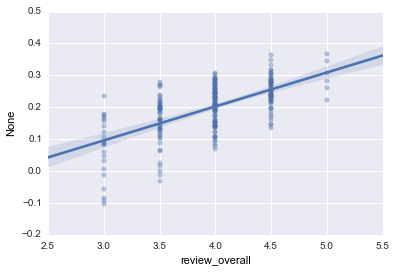

In [36]:
f = sb.regplot(my_reviews, pred[list(my_reviews.index)], scatter_kws=dict(alpha=.4))

### Model-based collaborative filtering

In _model-based collaborative filtering_ we will estimate parameters for both items and users simultaneously.  This apporach is considered to be the state of the art and gets generally the highest prediction accuracy.

The most popular model-based CF techniques use matrix decomposition techniques to find deeper structure in the ratings data.  For example, we could decompose the ratings matrix via SVD to reduce the dimensionality and extract latent variables. 

Once we identify the latent variables in the ratings matrix, we can express both users and items in terms of these latent variables.  As before, values in the item vectors represent the degree to which an item exhibits a given feature, and values in the user vectors represent user preferences for a given feature.  Ratings are constructed by taking dot products of user & item vectors in the latent feature space.

#### SVD-based models

In [37]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [38]:
%%time
n_components = 75  # 200   # number of beer classes
svd = TruncatedSVD(n_components)
X_red = svd.fit_transform(M.T)
explained_variance = svd.explained_variance_ratio_.sum()
print "Explained variance of the SVD step: %d%%" % (explained_variance * 100)
print "Dimensions feature matrix (old):", M.T.shape
print "Dimensions feature matrix (new):", X_red.shape

Explained variance of the SVD step: 57%
Dimensions feature matrix (old): (13964, 6420)
Dimensions feature matrix (new): (13964, 75)
CPU times: user 14.5 s, sys: 399 ms, total: 14.9 s
Wall time: 3.2 s


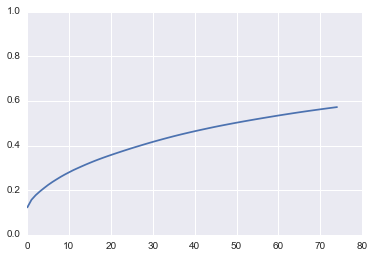

In [39]:
plt.plot(svd.explained_variance_ratio_.cumsum())
f = plt.ylim(0,1)

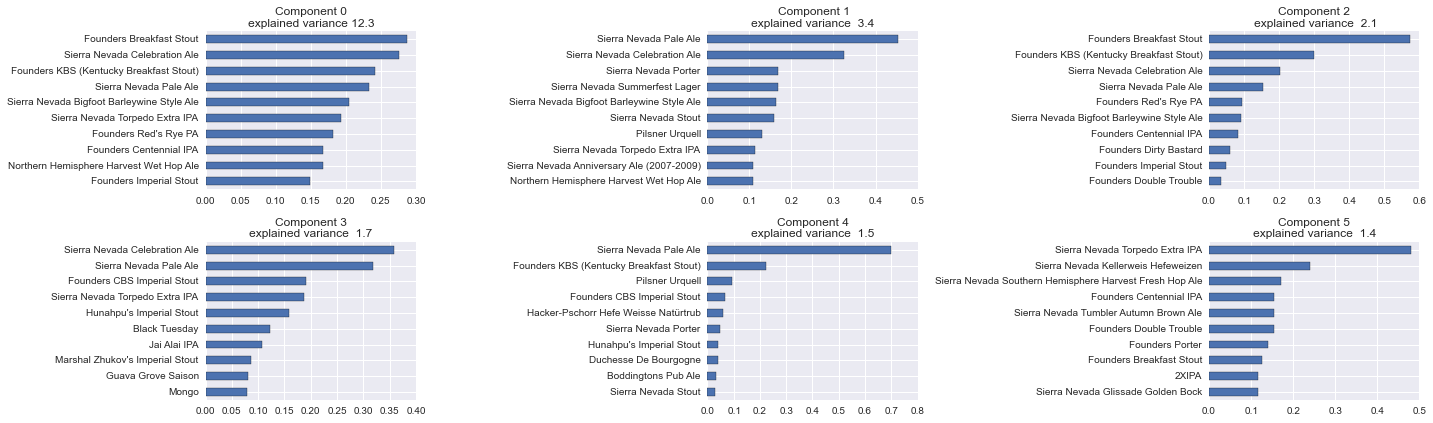

In [40]:
beers = M.index
top_beers = 10
n_rows, n_cols = 2, 3
top_components = n_rows * n_cols
f, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
for no, component in enumerate(svd.components_[:top_components]):
    ax = axes[no / n_cols][no % n_cols]
    s = pd.Series(svd.components_[no], index=beer_names[beers].values).sort(inplace=False)[-top_beers:]
    s.plot(kind='barh', ax=ax, title="Component %d\nexplained variance %4.1f" % 
           (no, 100 * svd.explained_variance_ratio_[no]))
f = plt.tight_layout()

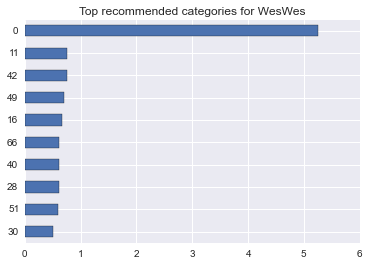

In [41]:
userid = list(M.columns).index(user)
recs = pd.Series(X_red[userid])
f = recs.sort(inplace=False)[-10:].plot(
    kind='barh', title='Top recommended categories for %s' % user)

In [42]:
beers_from_top_category = pd.Series(svd.components_[recs.argmax()], index=beer_names[beers].values)
print "Beers from top recommended category for %s:" % user,
print ', '.join(beers_from_top_category.sort(inplace=False)[-top_beers:].index)

Beers from top recommended category for WesWes: Founders Imperial Stout, Northern Hemisphere Harvest Wet Hop Ale, Founders Centennial IPA, Founders Red's Rye PA, Sierra Nevada Torpedo Extra IPA, Sierra Nevada Bigfoot Barleywine Style Ale, Sierra Nevada Pale Ale, Founders KBS (Kentucky Breakfast Stout), Sierra Nevada Celebration Ale, Founders Breakfast Stout


Take dot product again to get individual beers, recommended for user.  Note that beers are represented in different components, so this is really a different set than the one before.

In [43]:
beer_recs = X_red[userid].dot(svd.components_)
beer_recs = pd.Series(beer_recs, index=beer_names[beers].values)
print "Beers recommended for %s:" % user,
print ', '.join(beer_recs.sort(inplace=False)[-top_beers:].index)

Beers recommended for WesWes: Pumking, Stoudts Pils, Sierra Nevada Porter, Founders Backwoods Bastard, Hoptimum Double IPA - Beer Camp #19, Northern Hemisphere Harvest Wet Hop Ale, Founders KBS (Kentucky Breakfast Stout), Stoudt's Double IPA (India Pale Ale), Founders CBS Imperial Stout, Black Tuesday


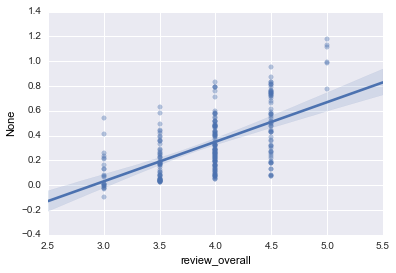

In [44]:
pred = pd.Series(recs.dot(svd.components_), index=beers)
f = sb.regplot(my_reviews, pred[list(my_reviews.index)], scatter_kws=dict(alpha=.4))